# Create a logistic regression model to predict TP53 mutation from gene expression data in TCGA

In [1]:
import datetime
import json
import os
import time

from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from dask_searchcv import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from vega import Vega
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from utils import fill_spec_with_data, get_model_coefficients, get_genes_coefficients

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration

In [3]:
# We're going to be building a 'TP53' classifier 
mutation_id = '7157' # TP53

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53*

## Load Data

In [4]:
%%time
path = os.path.join('download', 'expression-matrix.tsv.bz2')
expression_df = pd.read_table(path, index_col=0)

Wall time: 5min 25s


In [5]:
%%time
path = os.path.join('download', 'mutation-matrix.tsv.bz2')
mutation_df = pd.read_table(path, index_col=0)

Wall time: 3min 19s


In [6]:
%%time
path = os.path.join('download', 'expression-genes.tsv')
expression_genes_df = pd.read_table(path, index_col=0)

Wall time: 111 ms


In [7]:
path = os.path.join('download', 'covariates.tsv')
covariate_df = pd.read_table(path, index_col=0)

# Select acronym_x and n_mutations_log1p covariates only
selected_cols = [col for col in covariate_df.columns if col.startswith('acronym_')]
selected_cols.append('n_mutations_log1p')
covariate_df = covariate_df[selected_cols]

In [8]:
# The series holds TP53 Mutation Status for each sample
y = mutation_df[mutation_id]
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    1
TCGA-02-2485-01    1
TCGA-02-2486-01    0
TCGA-04-1348-01    1
Name: 7157, dtype: int64

In [9]:
print('Gene expression matrix shape: {}'.format(expression_df.shape))
print('Covariates matrix shape: {}'.format(covariate_df.shape))

Gene expression matrix shape: (7306, 20468)
Covariates matrix shape: (7306, 33)


## Set aside 10% of the data for testing

In [10]:
# Typically, this type of split can only be done 
# for genes where the number of mutations is large enough
X = pd.concat([covariate_df, expression_df], axis='columns')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# Here are the percentage of tumors with TP53
y.value_counts(True)

0    0.645907
1    0.354093
Name: 7157, dtype: float64

## Feature selection

In [11]:
def select_feature_set_columns(X, feature_set):
    """
    Select the feature set for the different models within the pipeline
    """
    n_covariates = len(covariate_df.columns)
    if feature_set == 'covariates':
        return X[:, :n_covariates]
    if feature_set == 'expressions':
        return X[:, n_covariates:]
    raise ValueError('feature_set not supported: {}'.format(feature_set))

# Creates the expression features by standarizing them and running PCA
# Because the expressions matrix is so large, we preprocess with PCA
# The amount of variance in the data captured by ~100 components is high
expression_features = Pipeline([
    ('select_features', FunctionTransformer(select_feature_set_columns,
        kw_args={'feature_set': 'expressions'})),
    ('standardize', StandardScaler()),
    ('pca', PCA())
])

# Creates the covariate features by selecting and standardizing them
covariate_features = Pipeline([
    ('select_features', FunctionTransformer(select_feature_set_columns,
        kw_args={'feature_set': 'covariates'})),
    ('standardize', StandardScaler())
])

## Elastic net classifier and model paraemeters

In [12]:
# Parameter Sweep for Hyperparameters
n_components_list = [50, 100]
regularization_alpha_list = [10 ** x for x in range(-3, 1)]
regularization_l1_ratio = 0.15

param_grids = {
    'full': {
        'features__expressions__pca__n_components' : n_components_list,
        'classify__alpha': regularization_alpha_list
    },
    'expressions': {
        'features__expressions__pca__n_components' : n_components_list,
        'classify__alpha': regularization_alpha_list
    },
    'covariates': {
        'classify__alpha': regularization_alpha_list
    }
}

# Classifier: Elastic Net
classifier = SGDClassifier(penalty='elasticnet',
                           l1_ratio=regularization_l1_ratio,
                           loss='log', 
                           class_weight='balanced',
                           random_state=0)

## Define pipeline and cross validation

In [13]:
# Full model pipelines
pipeline_definitions = {
    'full': Pipeline([
        ('features', FeatureUnion([
            ('expressions', expression_features),
            ('covariates', covariate_features)
        ])),
        ('classify', classifier)
    ]),
    'expressions': Pipeline([
        ('features', FeatureUnion([('expressions', expression_features)])),
        ('classify', classifier)
    ]),
    'covariates': Pipeline([
        ('features', FeatureUnion([('covariates', covariate_features)])),
        ('classify', classifier)
    ])
}

# Construct cross-validated grid searches
cv_pipelines = dict()
for model, pipeline in pipeline_definitions.items():
    cv = StratifiedKFold(n_splits=3, random_state=0)
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[model],
        cv=cv,
        n_jobs=1, 
        scoring='roc_auc',
    )
    cv_pipelines[model] = grid_search

In [14]:
# Fit the models
for model, pipeline in cv_pipelines.items():
    print('Fitting CV for model: {0}'.format(model))
    start_time = time.perf_counter()
    pipeline.fit(X=X_train, y=y_train)
    end_time = time.perf_counter()
    elapsed = datetime.timedelta(seconds=end_time - start_time)
    print('\truntime: {}'.format(elapsed))

Fitting CV for model: expressions
	runtime: 0:03:18.124787
Fitting CV for model: covariates
	runtime: 0:00:35.839733
Fitting CV for model: full
	runtime: 0:03:23.334892


In [15]:
# Best Parameters
for model, pipeline in cv_pipelines.items():
    print('#', model)
    print(pipeline.best_params_)
    print('cv_auroc = {:.3%}'.format(pipeline.best_score_))

# expressions
{'features__expressions__pca__n_components': 100, 'classify__alpha': 1}
cv_auroc = 87.822%
# covariates
{'classify__alpha': 0.01}
cv_auroc = 84.206%
# full
{'features__expressions__pca__n_components': 50, 'classify__alpha': 1}
cv_auroc = 87.907%


## Visualize hyperparameters performance

In [16]:
cv_results_df = pd.DataFrame()
for model, pipeline in cv_pipelines.items():
    df = pd.concat([
        pd.DataFrame(pipeline.cv_results_),
        pd.DataFrame.from_records(pipeline.cv_results_['params'])
    ], axis='columns')
    df['feature_set'] = model
    cv_results_df = cv_results_df.append(df)

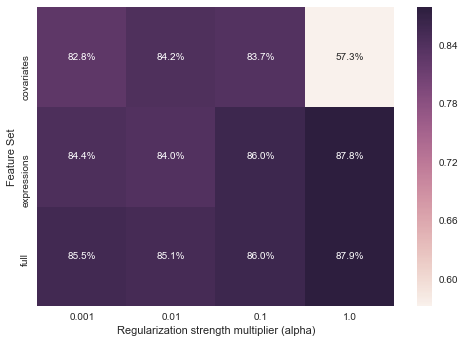

In [17]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_results_df,
                              values='mean_test_score', 
                              index='feature_set',
                              columns='classify__alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Feature Set');

## Use optimal hyperparameters to output ROC curve

In [18]:
y_pred_dict = {
    model: {
        'train': pipeline.decision_function(X_train),
        'test':  pipeline.decision_function(X_test)
    } for model, pipeline in cv_pipelines.items()
}

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_dict = {    
    model: {
        'train': get_threshold_metrics(y_train, y_pred_dict[model]['train']),
        'test':  get_threshold_metrics(y_test, y_pred_dict[model]['test'])
    } for model in y_pred_dict.keys()
}

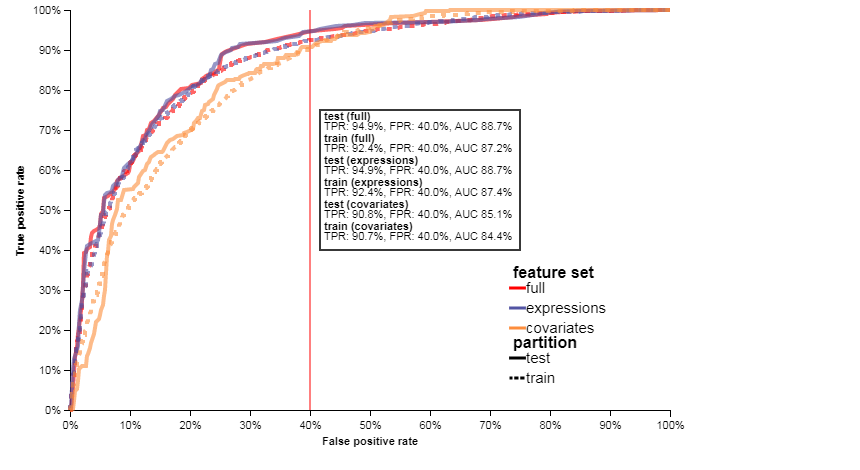

In [19]:
# Assemble the data for ROC curves
model_order = ['full', 'expressions', 'covariates']

auc_output = pd.DataFrame()
roc_output = pd.DataFrame()

for model in model_order:
    metrics_partition = metrics_dict[model]
    for partition, metrics in metrics_partition.items():
        auc_output = auc_output.append(pd.DataFrame({
            'partition': [partition],
            'feature_set': [model],
            'auc': metrics['auroc']
        }))
        roc_df = metrics['roc_df']
        roc_output = roc_output.append(pd.DataFrame({
            'false_positive_rate': roc_df.fpr,
            'true_positive_rate': roc_df.tpr,
            'partition': partition,
            'feature_set': model
        }))
auc_output['legend_index'] = range(len(auc_output.index))

with open('vega_specs/roc_vega_spec.json', 'r') as fp:
    vega_spec = json.load(fp)

final_spec = fill_spec_with_data(vega_spec, 
    {'roc': roc_output, 'legend_auc': auc_output})

Vega(final_spec)

## What are the classifier coefficients?

In [20]:
final_pipelines = {
    model: pipeline.best_estimator_
    for model, pipeline in cv_pipelines.items()
}
final_classifiers = {
    model: pipeline.named_steps['classify']
    for model, pipeline in final_pipelines.items()
}

coef_df = pd.concat([
    get_model_coefficients(classifier, model, covariate_df.columns)
    for model, classifier in final_classifiers.items()
])

In [21]:
# Signs of the coefficients by model
pd.crosstab(coef_df.feature_set, np.sign(coef_df.weight).rename('coefficient_sign'))

coefficient_sign,-1.0,0.0,1.0
feature_set,,,
covariates,15,5,13
expressions,15,74,11
full,13,58,12


### Top coefficients for covariates model

In [22]:
coef_df.query("feature_set == 'covariates'").head(10)

,feature,weight,abs,feature_set
32,n_mutations_log1p,0.676320,0.676320,covariates
27,acronym_THCA,-0.579283,0.579283,covariates
11,acronym_KIRC,-0.383792,0.383792,covariates
18,acronym_OV,0.381005,0.381005,covariates
3,acronym_CESC,-0.367353,0.367353,covariates
12,acronym_KIRP,-0.349670,0.349670,covariates
20,acronym_PCPG,-0.340781,0.340781,covariates
26,acronym_TGCT,-0.329432,0.329432,covariates
24,acronym_SKCM,-0.312592,0.312592,covariates
7,acronym_ESCA,0.306747,0.306747,covariates


### Top coefficients for full model

In [23]:
coef_df.query("feature_set == 'full'").head(10)

,feature,weight,abs,feature_set
8,PCA_8,-0.036748,0.036748,full
29,PCA_29,-0.036312,0.036312,full
2,PCA_2,-0.035470,0.035470,full
11,PCA_11,-0.032195,0.032195,full
24,PCA_24,0.030745,0.030745,full
37,PCA_37,0.029682,0.029682,full
22,PCA_22,-0.028933,0.028933,full
1,PCA_1,-0.027757,0.027757,full
34,PCA_34,-0.022778,0.022778,full
0,PCA_0,-0.020050,0.020050,full


### Top coefficients for individual _genes_ for full model

In [24]:
pca_for_full = (
    final_pipelines['full']
    .named_steps['features']
    .get_params()['expressions__pca']
    )
classifier_for_full = (
    final_pipelines['full']
    .named_steps['classify']
    )
gene_coefficients_for_full = get_genes_coefficients(
    pca_object=pca_for_full,
    classifier_object=classifier_for_full,
    expression_df=expression_df,
    expression_genes_df=expression_genes_df,
    num_covariates=len(covariate_df.columns)
    )
gene_coefficients_for_full.head(10)

,symbol,weight,abs,description
entrez_id,,,,
1643,DDB2,-0.003299,0.003299,damage specific DNA binding protein 2
8767,RIPK2,0.003266,0.003266,receptor interacting serine/threonine kinase 2
25879,DCAF13,0.003245,0.003245,DDB1 and CUL4 associated factor 13
3654,IRAK1,0.003142,0.003142,interleukin 1 receptor associated kinase 1
157378,TMEM65,0.003088,0.003088,transmembrane protein 65
79581,SLC52A2,0.003031,0.003031,solute carrier family 52 member 2
734,OSGIN2,0.002999,0.002999,oxidative stress induced growth inhibitor fami...
23729,SHPK,-0.002920,0.002920,sedoheptulokinase
4193,MDM2,-0.002902,0.002902,MDM2 proto-oncogene


### Top coefficients for individual _genes_ for expressions model

In [25]:
pca_for_expression = (
    final_pipelines['expressions']
    .named_steps['features']
    .get_params()['expressions__pca']
    )
classifier_for_expression = (
    final_pipelines['expressions']
    .named_steps['classify']
    )
gene_coefficients_for_expression = get_genes_coefficients(
    pca_object=pca_for_expression,
    classifier_object=classifier_for_expression,
    expression_df=expression_df,
    expression_genes_df=expression_genes_df
    )
gene_coefficients_for_expression.head(10)

,symbol,weight,abs,description
entrez_id,,,,
1643,DDB2,-0.003627,0.003627,damage specific DNA binding protein 2
8767,RIPK2,0.003552,0.003552,receptor interacting serine/threonine kinase 2
25879,DCAF13,0.003275,0.003275,DDB1 and CUL4 associated factor 13
734,OSGIN2,0.003173,0.003173,oxidative stress induced growth inhibitor fami...
4193,MDM2,-0.003125,0.003125,MDM2 proto-oncogene
6788,STK3,0.003107,0.003107,serine/threonine kinase 3
8704,B4GALT2,0.003103,0.003103,"beta-1,4-galactosyltransferase 2"
60401,EDA2R,-0.003084,0.003084,ectodysplasin A2 receptor
3654,IRAK1,0.003072,0.003072,interleukin 1 receptor associated kinase 1


## Investigate the predictions

In [26]:
predict_df = pd.DataFrame()
for model, pipeline in final_pipelines.items():
    df = pd.DataFrame.from_items([
        ('feature_set', model),
        ('sample_id', X.index),
        ('test_set', X.index.isin(X_test.index).astype(int)),
        ('status', y),
        ('decision_function', pipeline.decision_function(X)),
        ('probability', pipeline.predict_proba(X)[:, 1])
    ])    
    predict_df = predict_df.append(df)

predict_df['probability_str'] = predict_df['probability'].apply('{:.1%}'.format)

In [27]:
# Top predictions amongst negatives (potential hidden responders to a targeted cancer therapy)
(predict_df
    .sort_values('decision_function', ascending=False)
    .query("status == 0 and feature_set == 'full'")
    .head(10)
)

,feature_set,sample_id,test_set,status,decision_function,probability,probability_str
sample_id,,,,,,,
TCGA-L5-A4OH-01,full,TCGA-L5-A4OH-01,0,0,3.738964,0.976774,97.7%
TCGA-L5-A8NR-01,full,TCGA-L5-A8NR-01,0,0,3.636212,0.974325,97.4%
TCGA-EI-6513-01,full,TCGA-EI-6513-01,1,0,3.593692,0.973239,97.3%
TCGA-E2-A1LI-01,full,TCGA-E2-A1LI-01,0,0,3.445022,0.969082,96.9%
TCGA-HF-7136-01,full,TCGA-HF-7136-01,0,0,3.433403,0.968732,96.9%
TCGA-21-1081-01,full,TCGA-21-1081-01,0,0,3.245730,0.962519,96.3%
TCGA-L5-A4OS-01,full,TCGA-L5-A4OS-01,0,0,3.128641,0.958059,95.8%
TCGA-AO-A0J4-01,full,TCGA-AO-A0J4-01,0,0,3.105539,0.957121,95.7%
TCGA-B6-A0I1-01,full,TCGA-B6-A0I1-01,0,0,3.083023,0.956187,95.6%


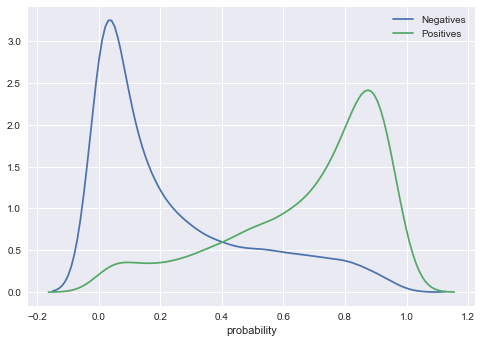

In [28]:
model_predict_df = predict_df.query("feature_set == 'full'")
ax = sns.distplot(model_predict_df.query("status == 0").probability, hist=False, label='Negatives')
ax = sns.distplot(model_predict_df.query("status == 1").probability, hist=False, label='Positives')